In [274]:
import os
import warnings
import kaggle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
warnings.simplefilter("ignore")

In [235]:
input_path = "../input/speech-accent-archive/"

if(not os.path.isdir(input_path)):
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('rtatman/speech-accent-archive', path='../input/speech-accent-archive/', unzip=True)

recordings_path = os.path.join(input_path,"recordings/recordings/")
df = pd.read_csv(os.path.join(input_path,"speakers_all.csv"))
display(df.head())

age  age_onset              birthplace  filename native_language   sex  \
0  24.0       12.0         koussi, senegal   balanta         balanta  male   
1  18.0       10.0          buea, cameroon  cameroon        cameroon  male   
2  48.0        8.0  hong, adamawa, nigeria  fulfulde        fulfulde  male   
3  42.0       42.0   port-au-prince, haiti   haitian         haitian  male   
4  40.0       35.0   port-au-prince, haiti   haitian         haitian  male   

   speakerid   country  file_missing?  Unnamed: 9  Unnamed: 10 Unnamed: 11  
0        788   senegal           True         NaN          NaN         NaN  
1       1953  cameroon           True         NaN          NaN         NaN  
2       1037   nigeria           True         NaN          NaN         NaN  
3       1165     haiti           True         NaN          NaN         NaN  
4       1166     haiti           True         NaN          NaN         NaN

Usuwamy niepotrzebne kolumny i wiersze z brakującymi nagraniami

In [236]:
#niepotrzebne kolumny
df = df.drop(df.columns[9:12], axis=1)

#usuwamy wiersze z brakującymi plikami
df = df[df['file_missing?']==False]


print("liczba plików")
print(len(os.listdir(recordings_path)))
print("liczba wierszy")
print(len(df.index))

#usuwamy 2 wiersze które nie mają nagrań
df = df[(df['filename'] + '.mp3').isin(os.listdir(recordings_path))]

display(df.head())

liczba plików
2138
liczba wierszy
2140


age  age_onset                         birthplace    filename  \
32  27.0        9.0             virginia, south africa  afrikaans1   
33  40.0        5.0             pretoria, south africa  afrikaans2   
34  43.0        4.0  pretoria, transvaal, south africa  afrikaans3   
35  26.0        8.0             pretoria, south africa  afrikaans4   
36  19.0        6.0            cape town, south africa  afrikaans5   

   native_language     sex  speakerid       country  file_missing?  
32       afrikaans  female          1  south africa          False  
33       afrikaans    male          2  south africa          False  
34       afrikaans    male        418  south africa          False  
35       afrikaans    male       1159  south africa          False  
36       afrikaans    male       1432  south africa          False

In [238]:
def display_audio(sample,columns):
    for idx in range(len(sample.index)):
        item = sample.iloc[[idx]]
        display(item[columns])
        recording = os.path.join(recordings_path, item.iloc[0]['filename'] + '.mp3')
        display(ipd.Audio(recording))
        
def display_waveplot(sample):
    for idx in range(len(sample.index)):
        item = sample.iloc[[idx]]
        recording = os.path.join(recordings_path, item.iloc[0]['filename'] + '.mp3')
        data, sampling_rate = librosa.load(recording)
        plt.figure(figsize=(15, 5))
        librosa.display.waveplot(data, sr=sampling_rate)
        plt.show()

przykładowe nagranie - głos kobiety


age  age_onset              birthplace    filename native_language  \
32  27.0        9.0  virginia, south africa  afrikaans1       afrikaans   

       sex  speakerid       country  file_missing?  
32  female          1  south africa          False

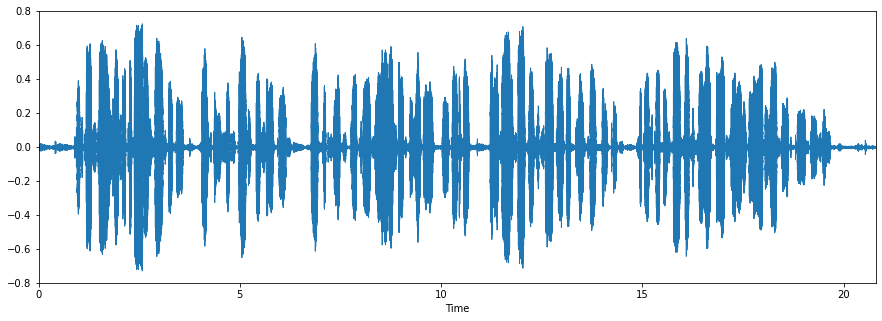

przykładowe nagranie - głos mężczyzny


age  age_onset              birthplace    filename native_language   sex  \
33  40.0        5.0  pretoria, south africa  afrikaans2       afrikaans  male   

    speakerid       country  file_missing?  
33          2  south africa          False

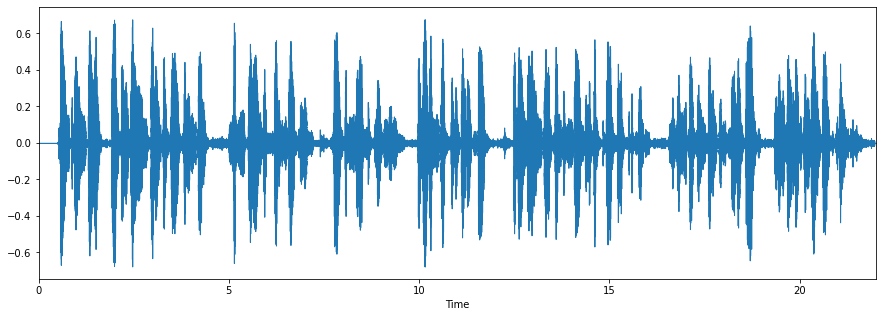

In [242]:
print("przykładowe nagranie - głos kobiety")
display_audio(df.iloc[[0]],df.columns)
display_waveplot(df.iloc[[0]])

print("przykładowe nagranie - głos mężczyzny")
display_audio(df.iloc[[1]],df.columns)
display_waveplot(df.iloc[[1]])

Średnia wieku, średnia wieku według płci, średnia wieku dla poszczególnych języków

In [243]:
print("Średnia wieku")
display(df[['age']].describe())

#usuwanie literówki
df = df.replace("famale","female")

print("Średnia wieku według płci")
display(df.groupby("sex")['age'].describe().sort_values(by=['count'],ascending=False))

print("Średnia wieku według języka")
display(df.groupby("native_language")['age'].describe().sort_values(by=['count'],ascending=False))

Średnia wieku


age
count  2138.000000
mean     33.076941
std      14.449986
min       0.000000
25%      22.000000
50%      28.000000
75%      41.000000
max      97.000000

Średnia wieku według płci


count       mean        std  min   25%   50%   75%   max
sex                                                              
male    1102.0  32.122051  13.453888  0.0  22.0  28.0  39.0  97.0
female  1036.0  34.092664  15.380759  0.0  22.0  29.0  43.0  89.0

Średnia wieku według języka


count       mean        std   min    25%   50%   75%   max
native_language                                                            
english          579.0  34.482729  16.734510   6.0  21.00  29.0  44.0  90.0
spanish          162.0  34.129630  13.972528  17.0  23.00  30.0  45.0  80.0
arabic           102.0  30.950980  12.047248  18.0  21.25  28.0  38.0  70.0
mandarin          65.0  30.015385   8.193924  18.0  24.00  28.0  34.0  53.0
french            63.0  33.333333  16.246091  18.0  21.00  27.0  39.0  78.0
...                ...        ...        ...   ...    ...   ...   ...   ...
nandi              1.0  35.000000        NaN  35.0  35.00  35.0  35.0  35.0
nama               1.0  44.000000        NaN  44.0  44.00  44.0  44.0  44.0
mortlockese        1.0  21.000000        NaN  21.0  21.00  21.0  21.0  21.0
moore              1.0  29.000000        NaN  29.0  29.00  29.0  29.0  29.0
zulu               1.0  24.000000        NaN  24.0  24.00  24.0  24.0  24.0

[200 rows x 8 columns]

## Wyodrębnianie atrybutów z nagrań

### MFCC - Mel Frequency Cepstral Coefficients
Reprezentuje krótkoterminowe widmo mocy dźwięku

age  age_onset     birthplace filename native_language     sex  \
1570  26.0       23.0  janow, poland  polish1          polish  female   

      speakerid country  file_missing?  
1570        277  poland          False

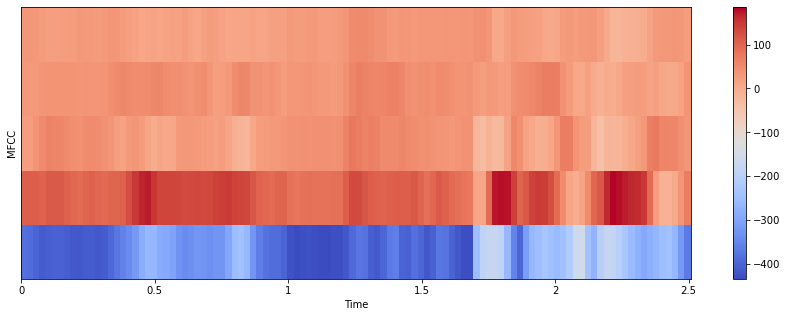

In [13]:
#Przykładowe nagranie - głos kobiety z Polski
female_polish = df[(df['native_language']=='polish') & (df['sex']=='female')].iloc[[0]]

display(female_polish)
recording = os.path.join(recordings_path, female_polish.iloc[0]['filename'] + '.mp3')
display(ipd.Audio(recording))
data, sampling_rate = librosa.load(recording,duration=2.5,offset=0.5)
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=5)
female_polish_mean = np.mean(mfcc,axis=0)
plt.figure(figsize=(15, 5))
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

### Średnia z MFCC

age  age_onset      birthplace  filename native_language   sex  \
1573  40.0       20.0  warsaw, poland  polish12          polish  male   

      speakerid country  file_missing?  
1573        883  poland          False

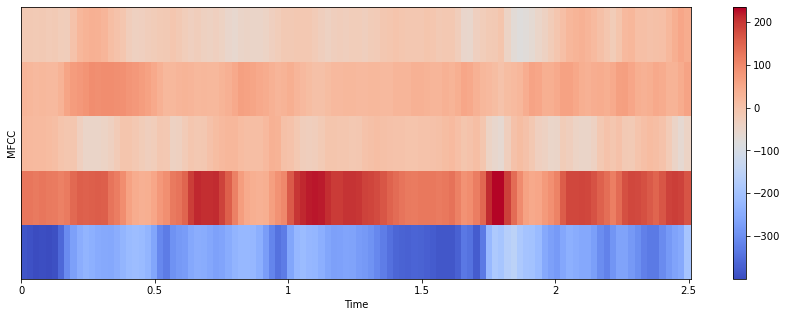

In [14]:
#Przykładowe nagranie - głos mężczyzny z Polski
male_polish = df[(df['native_language']=='polish') & (df['sex']=='male')].iloc[[0]]

display(male_polish)
recording = os.path.join(recordings_path, male_polish.iloc[0]['filename'] + '.mp3')
display(ipd.Audio(recording))
data, sampling_rate = librosa.load(recording,duration=2.5,offset=0.5)
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=5)
male_polish_mean = np.mean(mfcc,axis=0)
plt.figure(figsize=(15, 5))
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

Średnia z mfcc  
Widać duże różnice na wykresach

age  age_onset                    birthplace    filename  \
371  39.0        0.0  los angeles, california, usa  english106   

    native_language     sex  speakerid country  file_missing?  
371         english  female        408     usa          False

age  age_onset                birthplace    filename native_language  \
425  35.0        0.0  oakland, california, usa  english155         english   

      sex  speakerid country  file_missing?  
425  male        535     usa          False

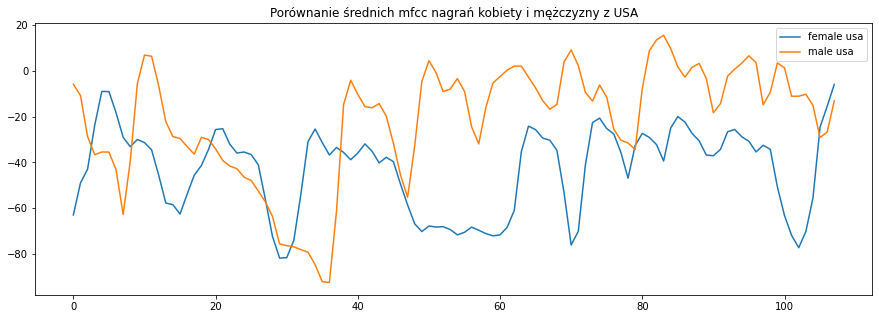

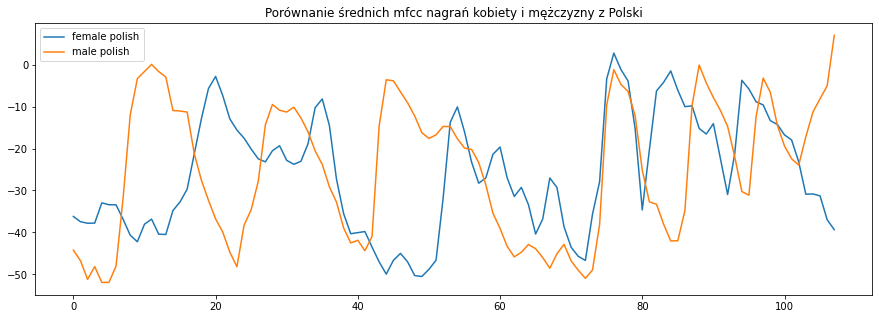

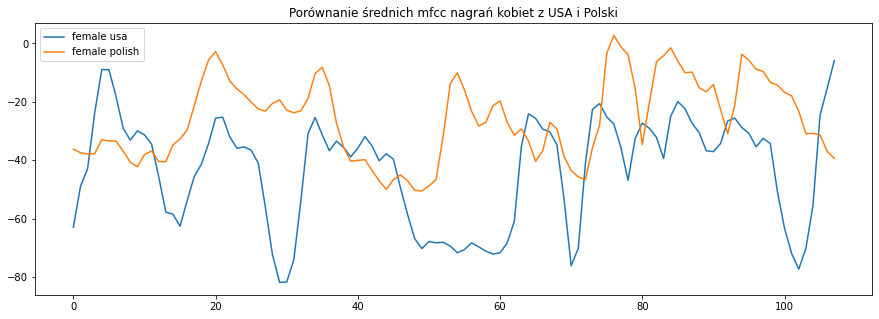

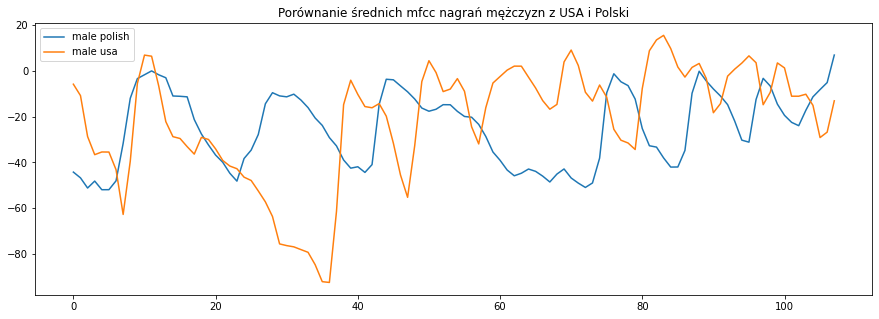

In [15]:
#Przykładowe nagranie - głos kobiety z USA
female_usa = df[(df['country']=='usa') & (df['native_language']=='english') & (df['sex']=='female') & (df['birthplace'].str.contains('california'))].iloc[[0]]
display(female_usa)
recording = os.path.join(recordings_path, female_usa.iloc[0]['filename'] + '.mp3')
display(ipd.Audio(recording))
data, sampling_rate = librosa.load(recording,duration=2.5,offset=0.5)
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=5)
female_usa_mean = np.mean(mfcc,axis=0)

#Przykładowe nagranie - głos mężczyzny z USA
male_usa = df[(df['country']=='usa') & (df['native_language']=='english') & (df['sex']=='male') & (df['birthplace'].str.contains('california'))].iloc[[0]]
display(male_usa)
recording = os.path.join(recordings_path, male_usa.iloc[0]['filename'] + '.mp3')
display(ipd.Audio(recording))
data, sampling_rate = librosa.load(recording,duration=2.5,offset=0.5)
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=5)
male_usa_mean = np.mean(mfcc,axis=0)


plt.figure(figsize=(15, 5))
plt.title('Porównanie średnich mfcc nagrań kobiety i mężczyzny z USA')
plt.plot(female_usa_mean,label='female usa')
plt.plot(male_usa_mean,label='male usa')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.title('Porównanie średnich mfcc nagrań kobiety i mężczyzny z Polski')
plt.plot(female_polish_mean,label='female polish')
plt.plot(male_polish_mean,label='male polish')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.title('Porównanie średnich mfcc nagrań kobiet z USA i Polski')
plt.plot(female_usa_mean,label='female usa')
plt.plot(female_polish_mean,label='female polish')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.title('Porównanie średnich mfcc nagrań mężczyzn z USA i Polski')
plt.plot(male_polish_mean,label='male polish')
plt.plot(male_usa_mean,label='male usa')
plt.legend()
plt.show()

## Funkcje do preprocessingu

In [156]:
class ExtractMFCC(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy()
        features = []
        for idx, filename in enumerate(X_.filename):
            recording = os.path.join(recordings_path, filename + '.mp3')
            data, sampling_rate = librosa.load(recording,duration=2.5,offset=0.5)
            mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=5)
            features.append(np.mean(mfcc,axis=0))
            print("{}/2138".format(idx+1), end = "\r")
        X_['mfcc'] = features
        return X_

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
class UnpackAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.concat([X.drop(['mfcc'], axis=1),pd.DataFrame(X[self.attribute_name].tolist(),index=X.index).add_prefix(self.attribute_name)],axis=1)

### przetwarzanie nagrań

In [157]:
data = ExtractMFCC().fit_transform(df)
data = UnpackAttributes('mfcc').fit_transform(data)
data.to_csv('speakers_processed.csv', index=False)

# Modele

### Najpierw spróbujemy przewidzieć płeć

In [276]:
data = pd.read_csv('speakers_processed.csv')
X = data.drop(['sex'], axis=1)
y = data.sex

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

preprocess_pipeline = Pipeline([('selector',DataFrameSelector(X.filter(regex='mfcc').columns)), 
                                ('scaler', StandardScaler())])

### SVM

In [252]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC())])

c=[1,10,50,100]
gamma=[0.0001,0.001,0.1,1]
param_grid=[{'classifier__C':c, 'classifier__kernel':['linear']},
      {'classifier__C':c, 'classifier__gamma':gamma, 'classifier__kernel':['poly', 'rbf']}]
grid=GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('selector',
                                                         DataFrameSelector(attribute_names=Index(['mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7',
       'mfcc8', 'mfcc9',
       ...
       'mfcc98', 'mfcc99', 'mfcc100', 'mfcc101', 'mfcc102', 'mfcc103',
       'mfcc104', 'mfcc105', 'mfcc106', 'mfcc107'],
      dtype='object', length=108))),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid=[{'classifier__C': [1, 10, 50, 100],
                          'classifier__kernel': ['linear']},
                         {'classifier__C': [1, 10, 50, 100],
                          'classifier__gamma': [0.0001, 0.001, 0.1, 1],


In [259]:
prediction = grid.predict(X_test)
print(metrics.accuracy_score(y_test,prediction))

0.7289719626168224


In [267]:
pipe.fit(X_train, y_train)

prediction = pipe.predict(X_test)
print(metrics.accuracy_score(y_test,prediction))

0.7551401869158878


Sprawdźmy kilka predykcji

In [268]:
sample = X_test.sample(n=5)
sample = sample.join(pd.DataFrame({'sex': label_encoder.inverse_transform(y_test)},index=X_test.index))
sample = sample.join(pd.DataFrame({'predicted_sex': label_encoder.inverse_transform(prediction)},index=X_test.index))

display_audio(sample,['sex','predicted_sex'])

sex predicted_sex
1966  female        female

sex predicted_sex
554  female        female

sex predicted_sex
49  male          male

sex predicted_sex
907  male        female

sex predicted_sex
1517  male          male

### RandomForest

In [286]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42))])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('selector',
                                  DataFrameSelector(attribute_names=Index(['mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7',
       'mfcc8', 'mfcc9',
       ...
       'mfcc98', 'mfcc99', 'mfcc100', 'mfcc101', 'mfcc102', 'mfcc103',
       'mfcc104', 'mfcc105', 'mfcc106', 'mfcc107'],
      dtype='object', length=108))),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                        random_state=42))])

In [287]:
prediction = pipe.predict(X_test)
print(metrics.accuracy_score(y_test,prediction))

0.7813084112149533
